In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy import stats
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, BatchNormalization, SpatialDropout2D
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from tensorflow.keras.metrics import BinaryCrossentropy as metricBinaryCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.image import resize_with_crop_or_pad
from tensorflow import cast, expand_dims,float32
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Import data and labels


In [3]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'

# Load Data 
with open(data_path+'/simulation_0.npy', 'rb') as a:    #'+str(sim_num)+'
    data_in_0 = np.load(a)  
with open(data_path+'/simulation_1.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
with open(data_path+'/simulation_25.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_25 = np.load(c)
    
# Load MC Truth
with open(data_path+'/inner_ph_0.npy', 'rb') as e:      #'+str(sim_num)+'
    inner_ph_in_0 = np.load(e)
with open(data_path+'/inner_ph_1.npy', 'rb') as f:      #'+str(sim_num)+'
    inner_ph_in_1 = np.load(f)
with open(data_path+'/inner_ph_25.npy', 'rb') as g:      #'+str(sim_num)+'
    inner_ph_in_25 = np.load(g)

### Reshaping data_0

In [4]:
d0 = data_in_0.reshape(-1, 31, 31 )
new_data_0 = np.array(resize_with_crop_or_pad(d0.T.reshape(31,31,-1), 32, 32)).T
new_data_0.shape

(54000, 32, 32)

### Concatenating multiple datasets

In [5]:
###### parameters #################
root_threshold = 10
###### fixed parameters ###########
n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
cam_side_length = 32
###################################

inner_ph_in_0 = inner_ph_in_0.reshape(n_cam_in_grain_0, -1)
inner_ph_in_1 = inner_ph_in_1.reshape(n_cam_in_grain_1, -1)

new_data_0 = new_data_0.reshape(-1, cam_side_length**2)
data_in_1 = data_in_1.reshape(-1, cam_side_length**2)

data_in = np.concatenate((new_data_0, data_in_1))
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_0, order='F'), np.ravel(inner_ph_in_1, order='F')))
# data_in = data_in_1 #new_data_0
# inner_ph_in = np.ravel(inner_ph_in_1, order='F')

label = np.zeros(inner_ph_in.shape[0])

for i in np.where( inner_ph_in > root_threshold )[0]:
    label[i] = 1

print('labelled-blind cameras :',label[label==1].shape[0])

data_in[data_in > 1000] = 1000

labelled-blind cameras : 1018


### Preprocessing

#### Apply RobustScaler

In [6]:
scaler_ = RobustScaler().fit(data_in)
scaler_data = scaler_.transform(data_in)#.reshape(-1, n_cam_in_grain, cam_side_length**2)
#scaler_data = RobustScaler().fit_transform(data_in)

In [7]:
normalize_ = np.max(scaler_data, axis = 1) #np.max(data.reshape(-1, cam_side_length**2), axis = 1)
normalize_[np.where(normalize_ == 0)[0]] = 1e-5
normalize_data = (scaler_data / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, cam_side_length**2)#.reshape(-1, n_cam_in_grain, cam_side_length**2) #data
normalize_data.shape

(112000, 1024)

In [8]:
# REASON WHY WE ADOPTED THE TECHNIQUE OF RESHAPING INNER PH ARRAY AND THE RAVEL IT WITH "order='F'"

#cam = 7
#evn = 6
#pix = 8
#ip = [ c1(e1,e2,e3,...), c2(e1,e2,e3,...), c3(), c(4), ... ]
#d.reshape = [ e1(c1 - pix)
#              e1(c2 - pix)
#              e1(c3 - pix)
#              e1( ....) 
#              ...
#              e2(c1 - pix)
#              e2(c2 - pix)
#              e2(...)
#              ...
#              e3(...)
# ]

#### UNCOMMENT ONLY THE FOLLOWING LINES #####################################à

# ip = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7])
# d = np.array([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7])
# print(d.reshape(-1,8).shape)
# print(ip.shape)

# ip = ip.reshape(7,6)
# #print(d.reshape(-1,8))
# print(np.ravel(ip, order='F'))

In [9]:
# EXPLAINATION OF HOW TO PROPERLY PAD 31X31 ARRAY 

# ip = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7])
# d0 = np.array([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7])

# d = d0.reshape(-1,8,7)
# dr = np.array(resize_with_crop_or_pad(d.T.reshape(7,8,-1), 8, 9))
# print(d.shape)
# print(dr.T.shape)

#### Split into test and training sets

In [10]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = scaler_data[:sep], scaler_data[sep:] #normalize_data[:800], normalize_data[800:]
train_label, test_label = label[:sep], label[sep:]

print(train_data.shape)
print(train_label.shape)

(89600, 1024)
(89600,)


In [11]:
train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# train_data /= renormalisation
# test_data /= renormalisation

# train_label = train_label.flatten()
# test_label = test_label.flatten()

train_label_ohe = to_categorical(train_label,2)
test_label_ohe = to_categorical(test_label,2)

train_label_ohe.shape

(89600, 2)

## Data augmentation

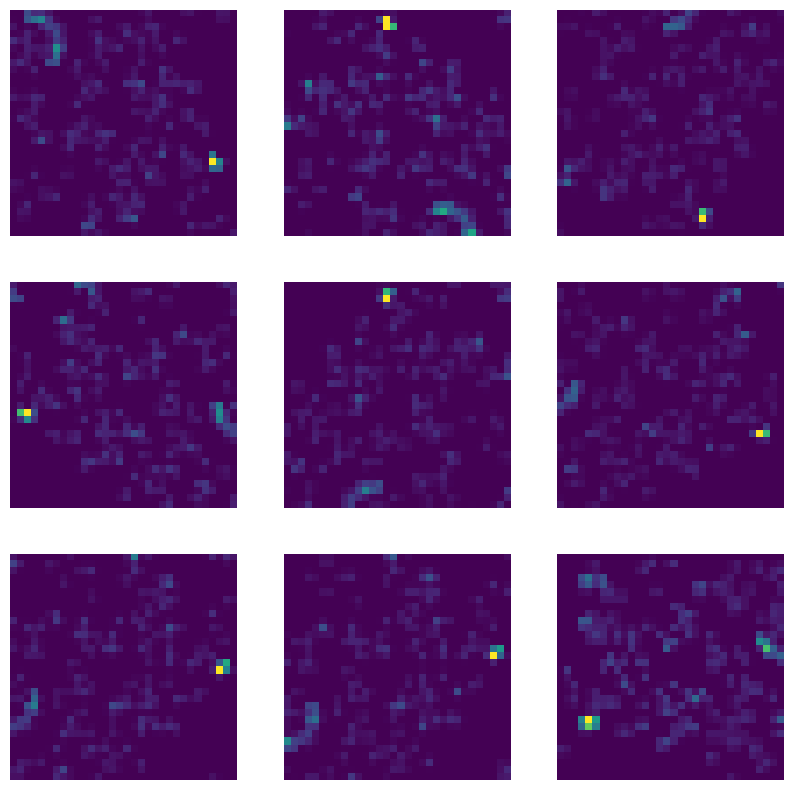

In [12]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

# Add the image to a batch.
image = cast(expand_dims(train_data[200], 0), float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## CNN model


In [13]:
#create model
model = Sequential()
#add model layers
#model.add(Input(shape=(None, None, 1)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(cam_side_length,cam_side_length,1)))
#model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Dropout(0.3))              
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
#model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
#model.add(Conv2D(128, kernel_size=3, activation='relu'))    #eliminate?
#model.add(Conv2D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))     #eliminate?
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))  #softmax

#compile model using accuracy to measure model performance
model.compile(optimizer='Nadam', loss=BinaryCrossentropy(from_logits=True), metrics=['binary_accuracy'])  #SparseCategoricalCrossentropy(from_logits=True) BinaryCrossentropy(from_logits=True)
                                                                                        #'binary_crossentropy''categorical_crossentropy'
                                                                                        #metrics=[metricBinaryCrossentropy()] 'binary_accuracy'
#model.summary()

# Train the model
history_callback = model.fit(train_data, train_label_ohe, batch_size=128, validation_data=(test_data, test_label_ohe), epochs=5) #_ohe
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#pd.DataFrame(history_callback.history).plot(logy=True)

Epoch 1/5


c:\Users\Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


700/700 [==============================] - 70s 91ms/step - loss: 0.2247 - binary_accuracy: 0.9805 - val_loss: 0.0285 - val_binary_accuracy: 0.9944
Epoch 2/5
700/700 [==============================] - 60s 86ms/step - loss: 0.0490 - binary_accuracy: 0.9884 - val_loss: 0.0252 - val_binary_accuracy: 0.9952
Epoch 3/5
700/700 [==============================] - 43s 62ms/step - loss: 0.0430 - binary_accuracy: 0.9896 - val_loss: 0.0262 - val_binary_accuracy: 0.9948
Epoch 4/5
700/700 [==============================] - 42s 60ms/step - loss: 0.0408 - binary_accuracy: 0.9898 - val_loss: 0.0254 - val_binary_accuracy: 0.9953
Epoch 5/5
700/700 [==============================] - 42s 60ms/step - loss: 0.0393 - binary_accuracy: 0.9902 - val_loss: 0.0226 - val_binary_accuracy: 0.9953


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

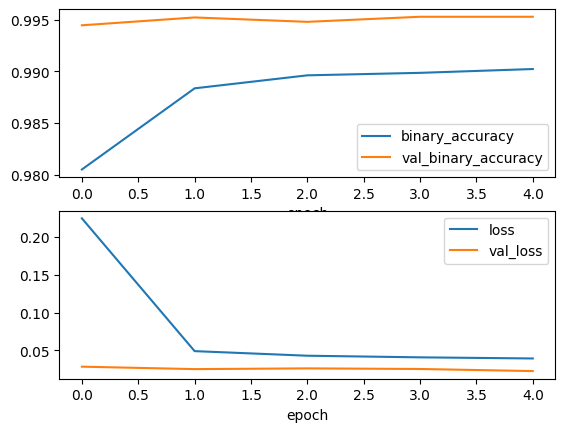

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history_callback.history['binary_accuracy'], label='binary_accuracy')
ax[0].plot(history_callback.history['val_binary_accuracy'], label='val_binary_accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history_callback.history['loss'], label='loss')
ax[1].plot(history_callback.history['val_loss'], label='val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [16]:
test_loss, test_acc = model.evaluate(test_data, test_label_ohe) #ohe?
print('test_acc:', test_acc)

pred = model.predict(test_data)
pred = np.around(pred) 

pred_dec = np.dot(pred, np.array([0,1], dtype='float32'))
pred_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))
cm = confusion_matrix(pred_lab, pred_dec)
prec = precision_score(pred_lab, pred_dec)
reca = recall_score(pred_lab, pred_dec)
f1 = f1_score(pred_lab, pred_dec)
roc = roc_auc_score(pred_lab, pred_dec)

print('labelled :', np.where(pred_lab==1)[0].size)  
print('predicted :',  np.where(pred_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)).shape[0])     
print('false negative :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)).shape[0]) 
print('\n')
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)
print('roc score :', roc)
#
#print(np.where(pred_dec==1))
#print(np.where(pred_lab==1))
non_scaled = data_in[sep:].reshape(-1, cam_side_length, cam_side_length, 1)
write_pdf = False
if write_pdf :
    pdf = PdfPages('./cnn_1p2.pdf')
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('TRUE positive')
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        ax[1].set_title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE positive')
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE negative')
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    pdf.close()

700/700 [==============================] - 3s 5ms/step - loss: 0.0226 - binary_accuracy: 0.9953
test_acc: 0.9952678680419922
700/700 [==============================] - 3s 5ms/step
labelled : 111
predicted : 5
true positive : 5
false positive : 0
false negative : 106


confusion matrix :
[[22289     0]
 [  106     5]]
precision : 1.0
recall : 0.04504504504504504
f1 score : 0.08620689655172413
roc score : 0.5225225225225225


## Prediction vs MC truth visualization

C:\Users\Pc\AppData\Local\Temp\ipykernel_34180\2659929529.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
C:\Users\Pc\AppData\Local\Temp\ipykernel_34180\2659929529.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this 

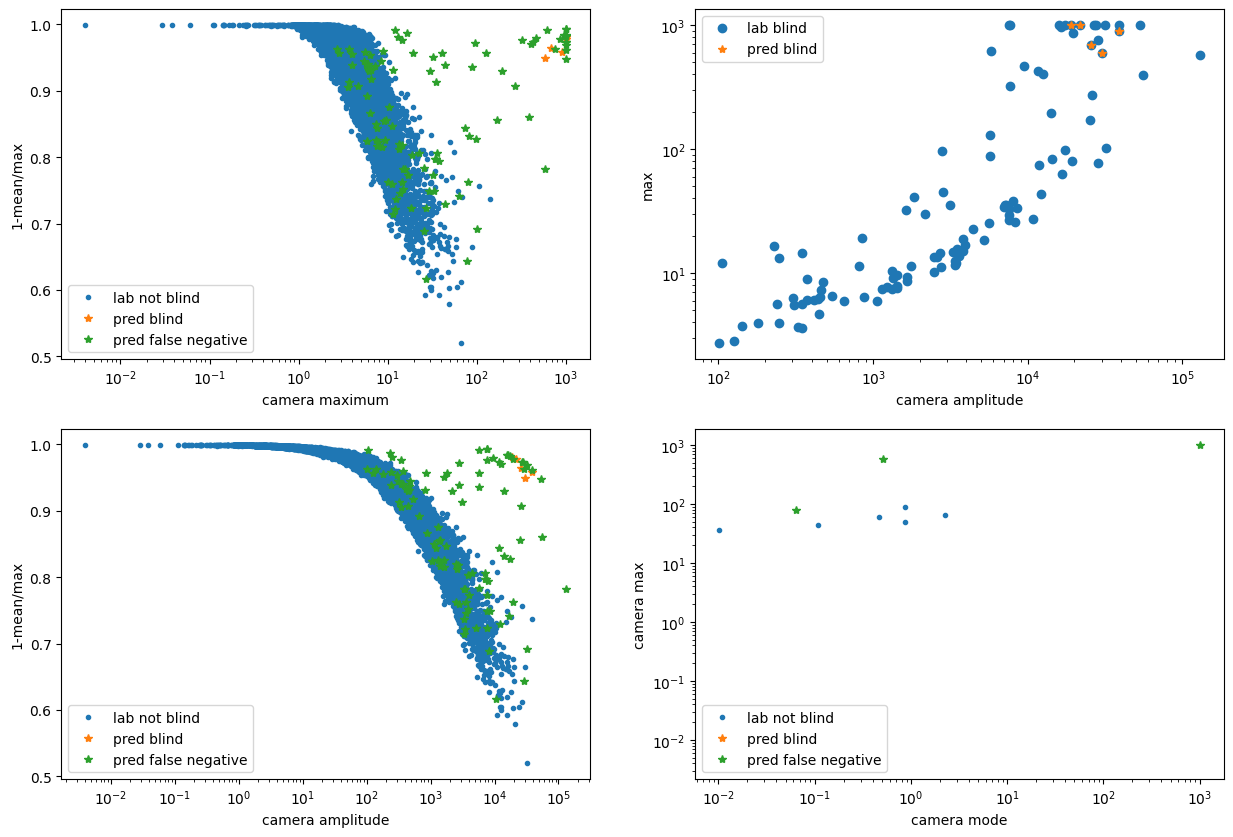

In [17]:
test_d = data_in[sep:]
#test_d = MaxAbsScaler().fit_transform(data_in[sep:])

lab_bl = test_d[np.where(pred_lab==1)]
lab_not_bl = test_d[np.where(pred_lab==0)]
pred_bl = test_d[np.where(pred_dec==1)]
pred_not_bl = test_d[np.where(pred_dec==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0))]

lab_not_bl_amp = np.sum(lab_not_bl, axis=1)
lab_bl_amp = np.sum(lab_bl, axis=1)
pred_bl_amp = np.sum(pred_bl, axis=1)
pred_not_bl_amp = np.sum(pred_not_bl, axis=1)
pred_fn_amp = np.sum(pred_fn, axis=1)
pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
lab_not_bl_mod = stats.mode(lab_not_bl, axis=1)[0].ravel()
pred_fn_mod = stats.mode(pred_fn, axis=1)[0].ravel()

lab_not_bl_max = np.max(lab_not_bl, axis=1)
lab_bl_max = np.max(lab_bl, axis=1)
pred_bl_max = np.max(pred_bl, axis=1)
pred_not_bl_max = np.max(pred_not_bl, axis=1)
pred_fn_max = np.max(pred_fn, axis=1)

lab_not_bl_mean = np.mean(lab_not_bl, axis=1)
lab_bl_mean = np.mean(lab_bl, axis=1)
pred_bl_mean = np.mean(pred_bl, axis=1)
pred_not_bl_mean = np.mean(pred_not_bl, axis=1)
pred_fn_mean = np.mean(pred_fn, axis=1)

ratio_bl_lab = lab_bl_mean/lab_bl_max
ratio_not_bl_lab = lab_not_bl_mean/lab_not_bl_max
ratio_bl_pred = pred_bl_mean/pred_bl_max
ratio_not_bl_pred = pred_not_bl_mean/pred_not_bl_max
ratio_fn_pred = pred_fn_mean/pred_fn_max

fig, ax = plt.subplots(2,2)
ax[0,0].plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
ax[0,0].plot(pred_bl_max, 1-ratio_bl_pred, '*', label='pred blind')
ax[0,0].plot(pred_fn_max, 1-ratio_fn_pred, '*', label='pred false negative')
# ax[0].yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('camera maximum')
ax[0,0].set_ylabel('1-mean/max')
ax[0,0].legend()

ax[0,1].plot(lab_bl_amp, lab_bl_max, 'o', label='lab blind')
ax[0,1].plot(pred_bl_amp, pred_bl_max, '*', label='pred blind')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('camera amplitude')
ax[0,1].set_ylabel('max')
ax[0,1].legend()

ax[1,0].plot(lab_not_bl_amp, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
ax[1,0].plot(pred_bl_amp, 1-ratio_bl_pred, '*', label='pred blind')
ax[1,0].plot(pred_fn_amp, 1-ratio_fn_pred, '*', label='pred false negative')
# ax[0].yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('camera amplitude')
ax[1,0].set_ylabel('1-mean/max')
ax[1,0].legend()

ax[1,1].plot(lab_not_bl_mod, lab_not_bl_max, '.', label='lab not blind')
ax[1,1].plot(pred_bl_mod, pred_bl_max, '*', label='pred blind')
ax[1,1].plot(pred_fn_mod, pred_fn_max, '*', label='pred false negative')

ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('camera mode')
ax[1,1].set_ylabel('camera max')
ax[1,1].legend()

fig.set_figwidth(15)
fig.set_figheight(10)

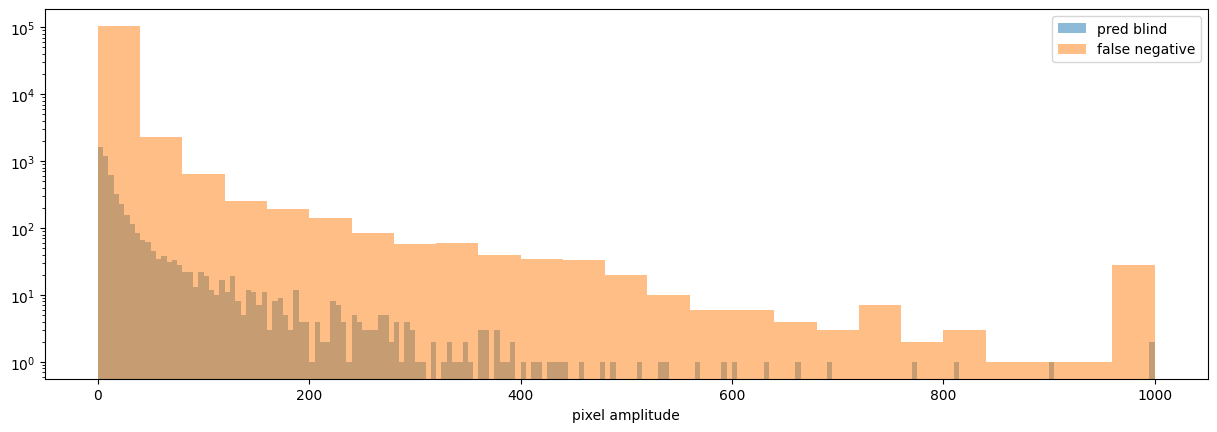

In [18]:
fig = plt.figure()

plt.hist(pred_bl.reshape(-1,1), 200, alpha = 0.5, label='pred blind');
plt.hist(pred_fn.reshape(-1,1), 25, alpha = 0.5, label='false negative');
#plt.hist(np.concatenate((pred_bl.reshape(-1,1), pred_fn.reshape(-1,1))), 200, histtype='step', ls='dashed')
plt.yscale('log')
plt.xlabel('pixel amplitude')
plt.legend()
fig.set_figwidth(15)

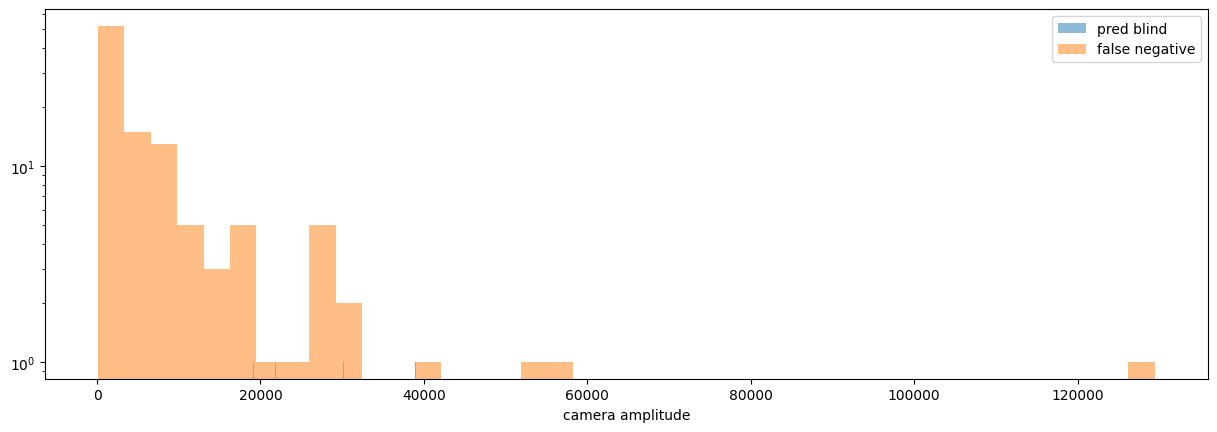

In [19]:
fig = plt.figure()

plt.hist(pred_bl_amp.reshape(-1,1), 200, alpha = 0.5, label='pred blind');
plt.hist(pred_fn_amp.reshape(-1,1), 40, alpha = 0.5, label='false negative');
#plt.hist(np.concatenate((pred_bl.reshape(-1,1), pred_fn.reshape(-1,1))), 200, histtype='step', ls='dashed')
plt.yscale('log')
plt.xlabel('camera amplitude')
plt.legend()
fig.set_figwidth(15)

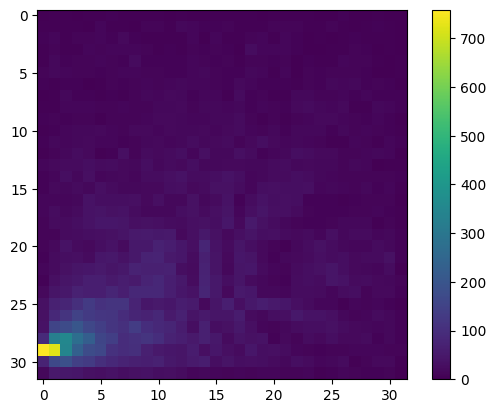

In [20]:
img = 100
plt.imshow(lab_bl[img].reshape(cam_side_length,cam_side_length))
plt.colorbar()

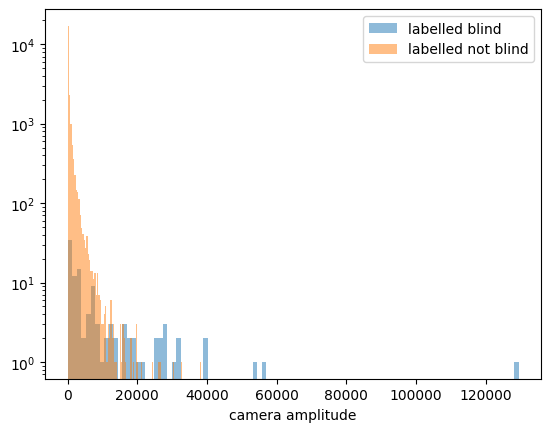

In [21]:
plt.hist(lab_bl_amp.reshape(-1,1), 100, alpha=0.5, label='labelled blind');
plt.hist(lab_not_bl_amp.reshape(-1,1), 100, alpha=0.5, label='labelled not blind');
plt.yscale('log')
plt.xlabel('camera amplitude')
plt.legend()

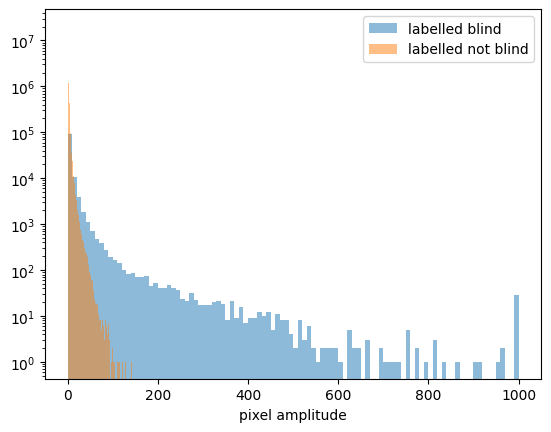

In [22]:
plt.hist(lab_bl.reshape(-1,1), 100, alpha=0.5, label='labelled blind');
plt.hist(lab_not_bl.reshape(-1,1), 100, alpha=0.5, label='labelled not blind');
plt.yscale('log')
plt.xlabel('pixel amplitude')
plt.legend()

## Train and Test sets visualization (blind only)

In [23]:
data_in[:sep].shape

(89600, 1024)

C:\Users\Pc\AppData\Local\Temp\ipykernel_34180\3992201345.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_not_bl_lab_t = lab_not_bl_mean_t/lab_not_bl_max_t


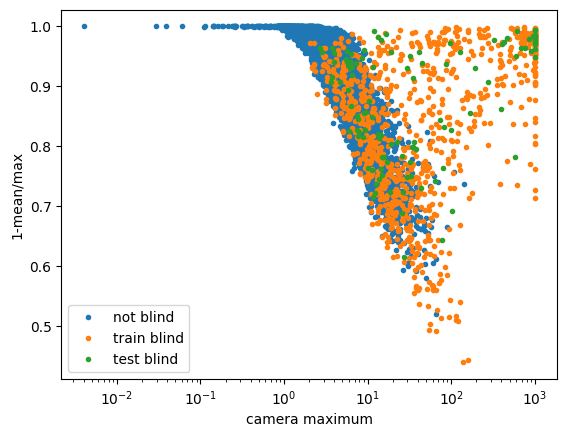

In [24]:
train_d = data_in[:sep]
#train_d = MaxAbsScaler().fit_transform(data_in[:sep])

lab_bl_t = train_d[np.where(train_label==1)]
lab_not_bl_t = train_d[np.where(train_label==0)]

lab_not_bl_amp_t = np.sum(lab_not_bl_t, axis=1)
lab_bl_amp_t = np.sum(lab_bl_t, axis=1)

lab_not_bl_max_t = np.max(lab_not_bl_t, axis=1)
lab_bl_max_t = np.max(lab_bl_t, axis=1)

lab_not_bl_mean_t = np.mean(lab_not_bl_t, axis=1)
lab_bl_mean_t = np.mean(lab_bl_t, axis=1)

ratio_bl_lab_t = lab_bl_mean_t/lab_bl_max_t
ratio_not_bl_lab_t = lab_not_bl_mean_t/lab_not_bl_max_t

plt.plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='not blind')
plt.plot(lab_bl_max_t, 1-ratio_bl_lab_t, '.', label='train blind')
plt.plot(lab_bl_max, 1-ratio_bl_lab, '.', label='test blind')
plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()

In [25]:
save_model = False
if save_model:
    model_json = model.to_json()
    with open('model_highRoc.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model_highRoc.h5')

In [26]:
# 20 epochs - layers 32 64 128
# previous was:  test_acc: 0.9894444346427917
# predicted : 60
# true positive : 55

# 40 epochs - layers 32 64 128
# test_acc: 0.9893518686294556
# predicted : 69
# true positive : 59

# 20 epochs - layers 64 128 256
# test_acc: 0.9888888597488403
# predicted : 54
# true positive : 49

# 20 epochs - layers 31 93 186
# test_acc: 0.9888888597488403
# predicted : 72
# true positive : 58

# 20 epochs - layers 32 64 128
# test_acc: 0.9893518686294556
# predicted : 63
# true positive : 56

# 20 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9889814853668213
# predicted : 57
# true positive : 51

# 30 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9887962937355042
# predicted : 57
# true positive : 50

# 40 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9892592430114746
# predicted : 58
# true positive : 53

# 50 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9896296262741089
# predicted : 64
# true positive : 58

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss='categorical_crossentropy'
# test_acc: 0.9900000095367432              # probably starts overfitting
# predicted : 64
# true positive : 60

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True)
# test_acc: 0.9902777671813965              
# predicted : 69
# true positive : 64
# subsequent data augmentation
# test_acc: 0.9894444346427917              
# predicted : 62
# true positive : 56

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.988703727722168
# predicted : 52
# true positive : 47

# 40 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9894444346427917
# predicted : 56
# true positive : 53
# precision : 0.9464285714285714
# recall : 0.3231707317073171
# f1 score : 0.4818181818181818

# 40 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9889814853668213
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9887962937355042              
# predicted : 47
# true positive : 45
# precision : 0.9574468085106383
# recall : 0.27439024390243905
# f1 score : 0.42654028436018954
# roc score : 0.6371011016428328

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9885185360908508
# predicted : 48
# true positive : 44
# precision : 0.9166666666666666
# recall : 0.2682926829268293
# f1 score : 0.4150943396226415
# roc score : 0.6339583008466414

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9891666769981384
# predicted : 49
# true positive : 48
# precision : 0.9795918367346939
# recall : 0.2926829268292683
# f1 score : 0.45070422535211263
# roc score : 0.6462944532604409

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.5 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.988611102104187
# predicted : 49
# true positive : 45
# precision : 0.9183673469387755
# recall : 0.27439024390243905
# f1 score : 0.4225352112676057
# roc score : 0.6370070813344463

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - model.add(Dense(64, activation='relu'))
# test_acc: 0.9881481528282166
# predicted : 42
# true positive : 39
# precision : 0.9285714285714286
# recall : 0.23780487804878048
# f1 score : 0.3786407766990291
# roc score : 0.6187614085618104

# 20 epochs - layers 32 64 128 - Dropout 0.3 eliminated(0.3) - loss='categorical_crossentropy' - DataAugmentation 
# test_acc: 0.988703727722168
# predicted : 50
# true positive : 46
# precision : 0.92
# recall : 0.2804878048780488
# f1 score : 0.4299065420560748
# roc score : 0.6400558618222512

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - sigmoid in Conv2D layers
# test_acc: 0.9850925803184509
# predicted : 39
# true positive : 19
# precision : 0.5428571428571428
# recall : 0.11585365853658537
# f1 score : 0.19095477386934676
# roc score : 0.5571746668011999

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - padding='same'
# test_acc: 0.988703727722168
# predicted : 44
# true positive : 43
# precision : 0.9772727272727273
# recall : 0.2621951219512195
# f1 score : 0.41346153846153844
# roc score : 0.6310505508214165

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9893518686294556
# predicted : 51
# true positive : 50
# precision : 0.9803921568627451
# recall : 0.3048780487804878
# f1 score : 0.4651162790697675
# roc score : 0.6523920142360506

# 100 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9893518686294556
# predicted : 53
# true positive : 51
# precision : 0.9622641509433962
# recall : 0.31097560975609756
# f1 score : 0.4700460829493088
# roc score : 0.6553937845696622

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9897222518920898
# predicted : 65
# true positive : 59
# precision : 0.9076923076923077
# recall : 0.3597560975609756
# f1 score : 0.5152838427947598
# roc score : 0.679595987855328

# 20 epochs - layers 32 64 128 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9889814853668213
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 20 epochs - layers 32 64 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9880555272102356
# predicted : 47
# true positive : 41
# precision : 0.8723404255319149
# recall : 0.25
# f1 score : 0.3886255924170616
# roc score : 0.6247179390748402

# 20 epochs - layers 32 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9877777695655823
# predicted : 40
# true positive : 36
# precision : 0.9
# recall : 0.21951219512195122
# f1 score : 0.3529411764705882
# roc score : 0.6095680569442024

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='binary_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 52
# true positive : 48
# precision : 0.9230769230769231
# recall : 0.2926829268292683
# f1 score : 0.4444444444444444
# roc score : 0.6461534227978609

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9892592430114746
# predicted : 52
# true positive : 50
# precision : 0.9615384615384616
# recall : 0.3048780487804878
# f1 score : 0.46296296296296297
# roc score : 0.6523450040818572

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9887962937355042
# predicted : 51
# true positive : 47
# precision : 0.9215686274509803
# recall : 0.2865853658536585
# f1 score : 0.43720930232558136
# roc score : 0.643104642310056

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9892592430114746
# predicted : 56
# true positive : 52
# precision : 0.9285714285714286
# recall : 0.3170731707317073
# f1 score : 0.4727272727272727
# roc score : 0.6583485447490804

# 20 epochs - layers 32 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.989120364189148
# predicted : 56
# true positive : 52
# precision : 0.9285714285714286
# recall : 0.3170731707317073
# f1 score : 0.4727272727272727
# roc score : 0.6583485447490804

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9895370602607727
# predicted : 60
# true positive : 56
# precision : 0.9333333333333333
# recall : 0.34146341463414637
# f1 score : 0.5
# roc score : 0.6705436667003

# 20 epochs - layers 32 64 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 51
# true positive : 47
# precision : 0.9215686274509803
# recall : 0.2865853658536585
# f1 score : 0.43720930232558136
# roc score : 0.643104642310056

# 20 epochs - layers 32 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.988703727722168
# predicted : 44
# true positive : 43
# precision : 0.9772727272727273
# recall : 0.2621951219512195
# f1 score : 0.41346153846153844
# roc score : 0.6310505508214165

# 20 epochs - layers 32 64 64 128 64 - SpatialDropout2D 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9886574149131775
# predicted : 51
# true positive : 46
# precision : 0.9019607843137255
# recall : 0.2804878048780488
# f1 score : 0.427906976744186
# roc score : 0.6400088516680579

# 20 epochs - layers 32 64 64 128 64 - SpatialDropout2D 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9886574149131775
# predicted : 47
# true positive : 44
# precision : 0.9361702127659575
# recall : 0.2682926829268293
# f1 score : 0.4170616113744076
# roc score : 0.6340053110008348

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9905555844306946
# predicted : 66
# true positive : 64
# precision : 0.9696969696969697
# recall : 0.3902439024390244
# f1 score : 0.5565217391304348
# roc score : 0.6950279309111255

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9901388883590698
# predicted : 66
# true positive : 61
# precision : 0.9242424242424242
# recall : 0.3719512195121951
# f1 score : 0.5304347826086956
# roc score : 0.6857405589851311

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=64 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9895370602607727
# predicted : 59
# true positive : 56
# precision : 0.9491525423728814
# recall : 0.34146341463414637
# f1 score : 0.5022421524663677
# roc score : 0.6705906768544933

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.990231454372406
# predicted : 65
# true positive : 62
# precision : 0.9538461538461539
# recall : 0.3780487804878049
# f1 score : 0.5414847161572053
# roc score : 0.6888833597813225

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9884722232818604
# predicted : 66
# true positive : 53
# precision : 0.803030303030303
# recall : 0.3231707317073171
# f1 score : 0.4608695652173913
# roc score : 0.6609742338491456

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9893518686294556
# predicted : 64
# true positive : 57
# precision : 0.890625
# recall : 0.3475609756097561
# f1 score : 0.4999999999999999
# roc score : 0.6734514167255249

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9902777671813965
# predicted : 64
# true positive : 62
# precision : 0.96875
# recall : 0.3780487804878049
# f1 score : 0.543859649122807
# roc score : 0.6889303699355157

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - camera_normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9899073839187622
# predicted : 55
# true positive : 55
# precision : 1.0
# recall : 0.3353658536585366
# f1 score : 0.502283105022831
# roc score : 0.6676829268292683

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - camera_normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9900925755500793
# predicted : 61
# true positive : 59
# precision : 0.9672131147540983
# recall : 0.3597560975609756
# f1 score : 0.5244444444444444
# roc score : 0.6797840284721012

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - Robust+normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9897222518920898
# predicted : 74
# true positive : 62
# precision : 0.8378378378378378
# recall : 0.3780487804878049
# f1 score : 0.5210084033613445
# roc score : 0.6884602683935827

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - Robust+normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9903703927993774
# predicted : 68
# true positive : 64
# confusion matrix :
# [[10633     4]
#  [  96    64]]
# precision : 0.9411764705882353
# recall : 0.3902439024390244
# f1 score : 0.5517241379310345
# roc score : 0.6949339106027389

############# new dataset ##################################

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9963793158531189
# predicted : 18
# true positive : 18
# precision : 1.0
# recall : 0.3
# f1 score : 0.4615384615384615
# roc score : 0.65

############ dataset 1 + 2 ####################################
# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9963616132736206
# predicted : 29
# true positive : 29
# precision : 1.0
# recall : 0.26126126126126126
# f1 score : 0.41428571428571426
# roc score : 0.6306306306306306

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9963839054107666
# predicted : 30
# true positive : 30
# precision : 1.0
# recall : 0.2702702702702703
# f1 score : 0.4255319148936171
# roc score : 0.6351351351351351



In [27]:
# ex = np.where(test_label==1)[0][91]
# predex = model.predict(test_data[ex].reshape(-1, cam_side_length, cam_side_length, 1))
# print(predex, np.around(predex))
# print('cam n° :',ex)

# cam = plt.pcolormesh(test_data[4303].reshape(cam_side_length, cam_side_length)*renormalisation)
# plt.colorbar(cam)  